Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [32]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization


In [33]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
!unzip /content/gdrive/MyDrive/app/upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration -d /content/gdrive/MyDrive/app/upgrad/CNN_Assignment

Archive:  /content/gdrive/MyDrive/app/upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration.zip
   creating: /content/gdrive/MyDrive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/
   creating: /content/gdrive/MyDrive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/
   creating: /content/gdrive/MyDrive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/
  inflating: /content/gdrive/MyDrive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/I

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [35]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')
print(data_dir_train)

/content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train


In [36]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [37]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [38]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [39]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [40]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

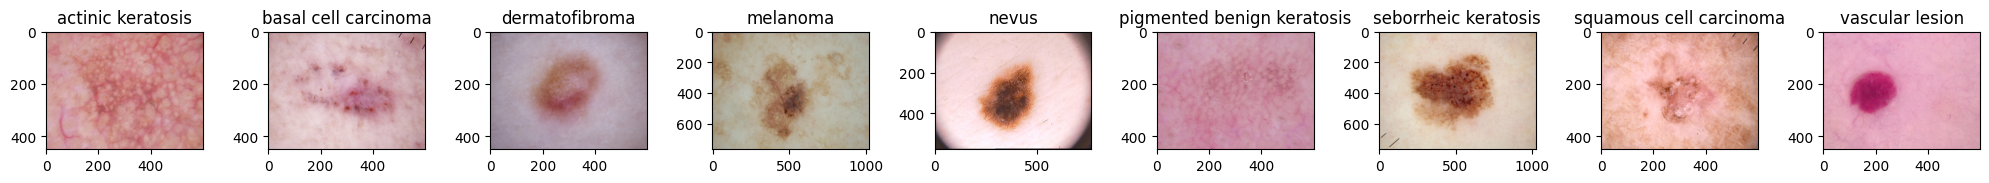

In [41]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt
from skimage import io
import random
num_classes = len(class_names)
fig, axes = plt.subplots(nrows=1, ncols=num_classes, figsize=(20, 3))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, img_class in enumerate(class_names):
    img_cls_path = data_dir_train / img_class
    img_files = list(img_cls_path.glob('*.jpg'))
    if img_files:
        rand_img_index = random.randint(0, len(img_files) - 1)
        random_image_path = img_files[rand_img_index]
        image = io.imread(str(random_image_path))
        ax = axes[i]
        ax.imshow(image)
        ax.set_title(img_class)

plt.tight_layout()
plt.show()



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [49]:
### Your code goes here
model = Sequential([

    Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(9, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [50]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [52]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 19s 81ms/step - loss: 1.8347 - accuracy: 0.3354 - val_loss: 1.6688 - val_accuracy: 0.4139
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6144 - accuracy: 0.4252 - val_loss: 1.5259 - val_accuracy: 0.5101
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4017 - accuracy: 0.5206 - val_loss: 1.5083 - val_accuracy: 0.4653
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3180 - accuracy: 0.5458 - val_loss: 1.3661 - val_accuracy: 0.5660
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2332 - accuracy: 0.5664 - val_loss: 1.4129 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.0995 - accuracy: 0.6077 - val_loss: 1.4974 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.0887 - accuracy: 0.6021 - val_loss: 1.3602 - val_accuracy: 0.5302
Epoch 8/20
5

### Visualizing training results

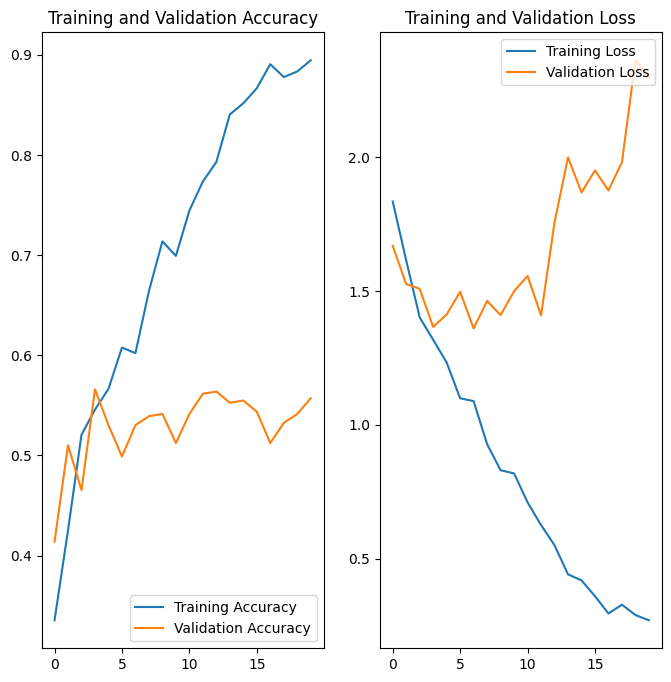

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit



### Write your findings here
As we see that final training accuracy comes out to be avout 89% and validation accuracy about 56%. Clearly there is huge difference between training and validation accuracy. Training accuracy looks reasonably good while validation accuracy is very poor. We also see the high loss during validation.

In [55]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

from tensorflow.keras.layers.experimental.preprocessing import Rescaling

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
        layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode='reflect',interpolation='bilinear',seed=None,fill_value=0.0),
        layers.experimental.preprocessing.RandomCrop(img_height,img_width)
    ]
)


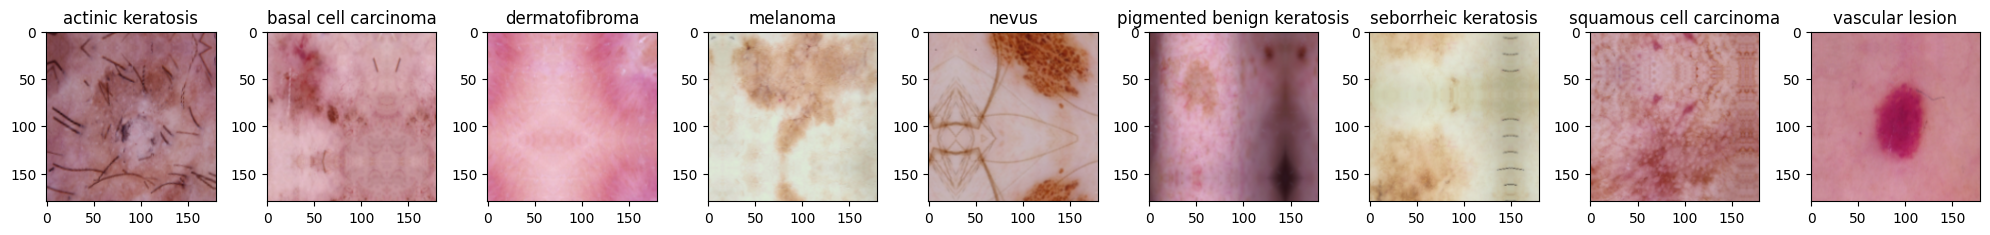

In [56]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
fig, axes = plt.subplots(nrows=1, ncols=num_classes, figsize=(20, 3))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, img_class in enumerate(class_names):
    img_cls_path = data_dir_train / img_class
    img_files = list(img_cls_path.glob('*.jpg'))
    if img_files:
        rand_img_index = random.randint(0, len(img_files) - 1)
        random_image_path = img_files[rand_img_index]
        image = io.imread(str(random_image_path))
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [img_height, img_width])
        image = tf.expand_dims(image, 0)
        aug_image = data_augmentation(image)
        aug_image = tf.squeeze(aug_image).numpy()
        ax = axes[i]
        ax.imshow(aug_image)
        ax.set_title(img_class)

plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [57]:
## You can use Dropout layer as there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
    data_augmentation,
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(9, activation='softmax')
])


### Compiling the model

In [58]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [59]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

### Training the model

In [60]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 37ms/step - loss: 2.2679 - accuracy: 0.1830 - val_loss: 2.0397 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 2.0456 - accuracy: 0.1920 - val_loss: 2.0246 - val_accuracy: 0.2081
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 2.0355 - accuracy: 0.1959 - val_loss: 2.0367 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 2.0348 - accuracy: 0.2026 - val_loss: 1.9737 - val_accuracy: 0.2192
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.9850 - accuracy: 0.2394 - val_loss: 1.9243 - val_accuracy: 0.2081
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.8669 - accuracy: 0.3013 - val_loss: 1.7795 - val_accuracy: 0.3490
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.8461 - accuracy: 0.3108 - val_loss: 1.6922 - val_accuracy: 0.3691
Epoch 8/20
56

### Visualizing the results

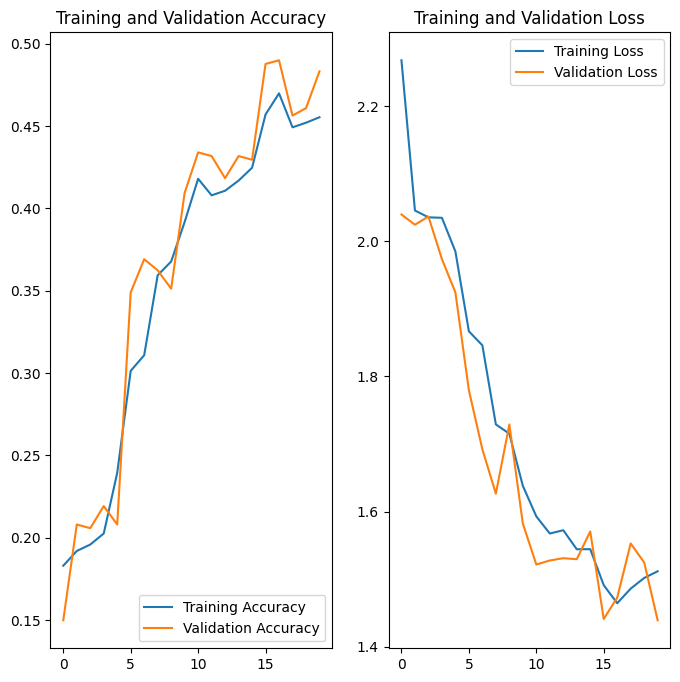

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: There is clear indication of underfitting, however the overfitting issues is gone.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [62]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train,'*','*.jpg'))]
les_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*','*.jpg'))]
len(path_list)

2239

In [63]:
df_dict_original = dict(zip(path_list,les_list))
original_df = pd.DataFrame(list(df_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/app/upgrad/CNN_Assign...,actinic keratosis
1,/content/gdrive/My Drive/app/upgrad/CNN_Assign...,actinic keratosis
2,/content/gdrive/My Drive/app/upgrad/CNN_Assign...,actinic keratosis
3,/content/gdrive/My Drive/app/upgrad/CNN_Assign...,actinic keratosis
4,/content/gdrive/My Drive/app/upgrad/CNN_Assign...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/app/upgrad/CNN_Assign...,vascular lesion
2235,/content/gdrive/My Drive/app/upgrad/CNN_Assign...,vascular lesion
2236,/content/gdrive/My Drive/app/upgrad/CNN_Assign...,vascular lesion
2237,/content/gdrive/My Drive/app/upgrad/CNN_Assign...,vascular lesion


Class=actinic keratosis, n=114 (5.092%)
Class=basal cell carcinoma, n=376 (16.793%)
Class=dermatofibroma, n=95 (4.243%)
Class=melanoma, n=438 (19.562%)
Class=nevus, n=357 (15.945%)
Class=pigmented benign keratosis, n=462 (20.634%)
Class=seborrheic keratosis, n=77 (3.439%)
Class=squamous cell carcinoma, n=181 (8.084%)
Class=vascular lesion, n=139 (6.208%)


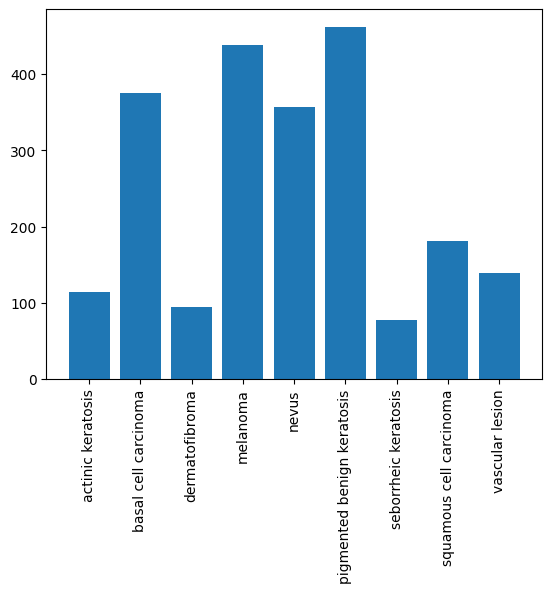

In [65]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt

# Split into input (X) and output (y) elements
X, y = original_df['Path'], original_df['Label']

# Label encode the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Store the mapping from encoded labels to original class names
labels_to_class_names = {index: label for index, label in enumerate(encoder.classes_)}

# Summarization of the distribution
counter = Counter(y_encoded)
for k, v in counter.items():
    perc = v / len(y_encoded) * 100
    class_name = labels_to_class_names[k]
    print('Class=%s, n=%d (%.3f%%)' % (class_name, v, perc))

# Plot the distribution
plt.bar(range(len(counter)), list(counter.values()), tick_label=[labels_to_class_names[k] for k in sorted(counter.keys())])
plt.xticks(rotation=90)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples? - As we see in the bar chart above, the 'seborrheic keratosis' has minimum number of samples.
#### - Which classes dominate the data in terms proportionate number of samples? - 'pigmented benign keratosis' has maximum number of samples.




#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [66]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [67]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset / i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C827EC85B70>: 100%|██████████| 500/500 [00:27<00:00, 17.93 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C827EC96A10>: 100%|██████████| 500/500 [00:28<00:00, 17.50 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C827A3FEE60>: 100%|██████████| 500/500 [00:25<00:00, 19.61 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7C827EDEB250>: 100%|██████████| 500/500 [01:51<00:00,  4.47 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2565x2000 at 0x7C827A3CDE70>: 100%|██████████| 500/500 [01:35<00:00,  5.22 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C827A39BD30>: 100%|██████████| 500/500 [00:19<00:00, 25.68 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7C827EC94760>: 100%|██████████| 500/500 [00:44<00:00, 11.26 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C827A376DA0>: 100%|██████████| 500/500 [00:20<00:00, 24.39 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C82890E0C40>: 100%|██████████| 500/500 [00:19<00:00, 25.16 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [68]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [69]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030826.jpg_e63ffe5c-dd0c-421a-97b0-9b909a51937a.jpg',
 '/content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029141.jpg_62fa407e-3958-4b59-acbd-53d75140c1f6.jpg',
 '/content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027896.jpg_cc042829-75be-48b7-895b-1a4ba5bd9ffd.jpg',
 '/content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033151.jpg_6fe8b014-614c-465b-b1e3-b37f6d0957a8.jpg',
 '/content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISI

In [70]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [71]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [72]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-72-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [73]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [74]:
batch_size = 32
img_height = 180
img_width = 180

In [75]:
# For convenience, let us set up the path for the training and validation sets here again
data_dir_train = os.path.join('/content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = os.path.join('/content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')
print(data_dir_train)

/content/gdrive/My Drive/app/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train


#### **Todo:** Create a training dataset

In [76]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  ## Todo choose the correct parameter value, so that only training data is refered to,,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [77]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [81]:
## your code goes here
model = Sequential([

    Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    Conv2D(16, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(32, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dropout(0.25),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(9, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [82]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [86]:

## Your code goes here, use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/50
169/169 [==============================] - 34s 192ms/step - loss: 0.2790 - accuracy: 0.8974 - val_loss: 0.8256 - val_accuracy: 0.7751
Epoch 2/50
169/169 [==============================] - 38s 222ms/step - loss: 0.2900 - accuracy: 0.8986 - val_loss: 1.0330 - val_accuracy: 0.7372
Epoch 3/50
169/169 [==============================] - 33s 192ms/step - loss: 0.2449 - accuracy: 0.9091 - val_loss: 0.9923 - val_accuracy: 0.7216
Epoch 4/50
169/169 [==============================] - 35s 203ms/step - loss: 0.2805 - accuracy: 0.9026 - val_loss: 1.3025 - val_accuracy: 0.6325
Epoch 5/50
169/169 [==============================] - 33s 190ms/step - loss: 0.2554 - accuracy: 0.9091 - val_loss: 1.4992 - val_accuracy: 0.6578
Epoch 6/50
169/169 [==============================] - 34s 195ms/step - loss: 0.2103 - accuracy: 0.9243 - val_loss: 1.1338 - val_accuracy: 0.7075
Epoch 7/50
169/169 [==============================] - 38s 220ms/step - loss: 0.2155 - accuracy: 0.9216 - val_loss: 1.9559 - val_ac

#### **Todo:**  Visualize the model results

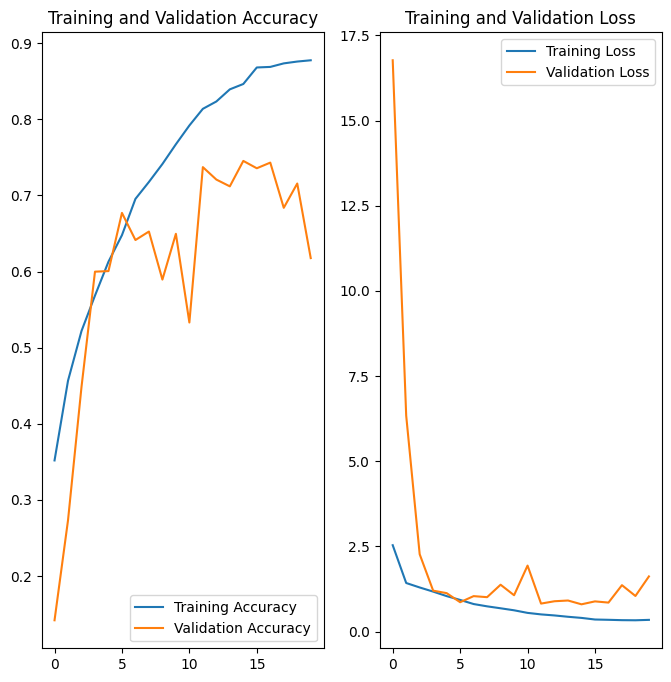

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We see there there is clear improvement after rebalancing the classes. There is no issue of underfitting this time. However there is some overfitting is still there which could be improved further with suitable CNN architecture (include more dropouts etc).

